# Memory Structure 
 - t_Before, t_After, A0, A1  = 4 bytes, 4 bytes, 4 bytes, 4 bytes = 16 bytes
 - Header = 3 x 4 bytes values  = 12 bytes



In [4]:
import numpy as np
import matplotlib.pyplot as plt


binary_file = True
outside_file = False

# get file memory size 

if binary_file == True:
    """ Extract Binary information from our files """
    import struct

    path = 'data/00020003.DAT'  # Update this to the actual path
    header = [0, 0, 0]  # Initialize header variable as a list of 3 integers
    arrays = [[], [], [], []]  # Initialize 4 arrays
    # print(header)
    with open(path, mode='rb') as file:
        # Read the first 3 values aka 12 bytes into the header
        header = list(struct.unpack('<3I', file.read(12)))
        # header = list(struct.unpack('<2I', file.read(8)))

        while True:
            data = file.read(16)  # Reading 16 bytes at a time (4 bytes for each interval)
            if not data:  # If data is empty
                break

            # Extract values using struct.unpack
            values = struct.unpack('<4I', data)

            # Extract values manually without using struct.unpack
            # values = (
            #     int.from_bytes(data[0:4], 'little'),
            #     int.from_bytes(data[4:8], 'little'),
            #     int.from_bytes(data[8:12], 'little'),
            #     int.from_bytes(data[12:16], 'little')
            # )

            # Add values to respective arrays
            arrays[0].append(values[0])
            arrays[1].append(values[1])
            arrays[2].append(values[2])
            arrays[3].append(values[3])

    print("Header:", header)
    print("time1:", np.array(arrays[0][:5]))
    print("time2:", np.array(arrays[1][:5]))
    print("BOF:", np.array(arrays[0][0]))
    print("EOF:", np.array(arrays[1][-1]))
    print("A0:", arrays[2][:5])
    print("A1:", arrays[3][:5])
    print("num of points:", len(arrays[0]))

    t1 = np.array(arrays[0]) # time before data collection 
    t2 = np.array(arrays[1]) # time after data collection 


if outside_file == True: 
    from scripts.analysis_IRIS import analyze, quickLook, extract_params
    # directory_path = "../M02M4/data/M0_tAv/50_1500_20/05100001.TXT"
    # directory_path = "../M02M4/data/M0_tAv/100_500_20/09060001.TXT"
    directory_path = "../M02M4/data/M4_tAv/50_1500_20/05090001.TXT"
    # Apply analyze function and get the resulting dictionary
    quickLook(directory_path, save_png=False, plot_all=True, plot_hist_sampletime=False)
    t, t1, t2, v0, v1, samples_averaged, inter_sample, inter_average = extract_params(directory_path)


Header: [0, 0, 12]
time1: [5214376 5214948 5215522 5216096 5216668]
time2: [5214933 5215507 5216081 5216653 5217225]
BOF: 5214376
EOF: 6214619
A0: [1031, 1041, 1041, 1038, 1037]
A1: [25150, 25161, 25163, 25152, 25148]
num of points: 1652


In [5]:
# Parameters 
print("\n\tPARAMETERS") #------------------------------------------------------------------------
if outside_file == False:
    inter_sample = header[0]
    inter_average = header[1]
    samples_averaged = header[2]
print('inter_sample (us):\t\t', inter_sample)
print('inter_average (us):\t\t', inter_average)
print('samples_averaged:\t\t', samples_averaged)

# Expected time spent sampling 
print("\n\tTIME SPENT SAMPLING - T2-T1") #------------------------------------------------------------------------
t_s_expected = samples_averaged*inter_sample + inter_average
print('Expected - No overhead (us):\t', t_s_expected)
print(f'\t( samples_av:{samples_averaged} x inter_sample:{inter_sample} ) + inter_av:{inter_average}')
# Actual Time spent sampling 
t_s = t2 - t1 
t_s_med = np.median(t_s) # 2000 us
print("Actual - median (us):\t\t", t_s_med)
t_s_diff = t_s_med - t_s_expected

print("diff (us):\t\t\t",round(t_s_diff,3))
#----------------------------------------------------------------------------------------------------------------

print("\n\tMEDIAN GAP - BETWEEN AV. POINTS - T1-T2") #-----------------------------------------------------------
# Expected gap 
print("Expected - inter_average (us):\t", inter_average)
# Actual Gaps 
t_g = t1[1:] - t2[:-1]
t_g_med = np.median(t_g) # ~500 us
print("Actual - median gap (us):\t", t_g_med)
# t_g_err = abs(t_g_med - inter_average)/inter_average
# print("% err:\t\t\t\t", round(t_g_err*100,3))
print("Smallest gap (us):\t\t", min(t_g))
print("Largest gap (ms):\t\t", max(t_g/1e3))
#----------------------------------------------------------------------------------------------------------------


print('\n\tLARGE GAPS - TIME') #---------------------------------------------------------------------------------
# Averaged Time
t_mid = (t1+t2)/2
# Voltage 
if outside_file == False: 
    d0 = np.array(arrays[2])
    d1 = np.array(arrays[3])
    v0 = (d0/samples_averaged)*(3.3/4096)
    v1 = (d1/samples_averaged)*(3.3/4096)

# Make a list of the time differences (gaps) between adjacent points:
dt = t_mid - np.roll(t_mid,1)
# skip 1st value
dt = dt[1:]
# Collect gaps larger than the - Actual Time Spent Sampling 
gap_qualifier = t_s_med*1.5
long_gap = np.where(dt > gap_qualifier)[0]
print('Expecting # of gaps: \t\t', len(long_gap))
print('Large gap >= Qualifier (us):\t', gap_qualifier)

# look at the index locations of large gaps
# print('num, idx, gap size')
for count, value in enumerate(long_gap):
    # print(count, value ,dt[value])
    0
# Compute the number of lines per write and bytes sent
dt_idx = long_gap - np.roll(long_gap,1)
dt_idx = dt_idx[1:]
print('')
print('Median Gap (us): \t\t', np.median(dt))
print('Median LARGE gap size (us):\t', np.median(dt[long_gap]))
print('Smallest Gap (us):\t\t', np.min(dt))
print('Smallest LARGE gap (us):\t', np.min(dt[long_gap]))
print('Largest Gap (us):\t\t', np.max(dt))
print('Largest LARGE gap (us):\t\t', np.max(dt[long_gap]))
#----------------------------------------------------------------------------------------------------------------

print('\n\tLARGE GAPS - LINES AND BYTES') #-----------------------------------------------------------------------
print('Median # of lines:\t\t', np.median(dt_idx))
print('Median # of Bytes:\t\t', np.median(dt_idx)*16)
print('Modulo of 512 Bytes:\t\t', round((np.median(dt_idx)*16)/512,2))
#----------------------------------------------------------------------------------------------------------------

print("\n\tEXPECTED BYTE AND LINE COUNT")#-----------------------------------------------------------------------
# Expected # of bytes per line written 
print('Expected # of Bytes per line:\t\t', 16)
# Expected large gap
print("Expected byte chunk due to SD write:\t", 512)
print("Expected # of lines written per chunk:\t", 512/16)
#----------------------------------------------------------------------------------------------------------------

print('\n\tFILE LENGTH') #---------------------------------------------------------------------------------------       
# Confirm times add up to the correct file length 
# Actual file time
t_mid = t_mid - t_mid[0]
file_t_actual = t_mid[-1]
print('Actual File length (s):\t\t',round(file_t_actual/1e6,3))
# Calculated time based on median gaps found 
small_gap = np.where(dt < gap_qualifier)[0]
file_t = len(dt[long_gap])*np.median(dt[long_gap]) + t_s_med*len(small_gap)
print('Calculation (s):\t\t',round(file_t/1e6,3))
print('\t# of large gaps x median large gap + # of median gap x median gap')
file_t_err = abs(file_t_actual - file_t)/file_t
print('% err:\t\t\t\t', round(file_t_err*100,3))
#----------------------------------------------------------------------------------------------------------------

print('\n\tTIME BETWEEN LARGE GAPS') #---------------------------------------------------------------------------
# Did: t[0], t[1]-(t[0+1]) , t[2] - (t[1]+1), ...
dt_b4_write = []
dt_b4_write.append(t_mid[long_gap[0]])
for i in range(1,len(long_gap[1:])): 
    new_val = t_mid[long_gap[i]] - (t_mid[long_gap[i-1]+1])
    dt_b4_write.append(new_val)
dt_b4_med = np.median(dt_b4_write)
print("Actual time of data collection...\n\t... b4 write - median (ms):\t", dt_b4_med/1e3)
print("Max dt (ms):\t\t\t\t", np.max(dt_b4_write)/1e3)
print("Min dt (ms):\t\t\t\t", np.min(dt_b4_write)/1e3)
#----------------------------------------------------------------------------------------------------------------

# Frequency from examining lines 
print('\n\tFREQUENCY') #---------------------------------------------------------------------------------------
# Frequency of averaging 
freq2 = samples_averaged/t_s_med
print('Samples Averaged Frequency (Hz):\t\t', round(freq2*1e6,2))
print(f'\tSamples Averaged {samples_averaged} / median time spent sampling {t_s_med} us')
# Frequency of collection not including write gaps
freq = np.median(dt_idx)/dt_b4_med
print("\nFrequency - not including write gaps (Hz):\t", round(freq*1e6,3))
print(f'\t{np.median(dt_idx)} lines / collection time {round(dt_b4_med/1e3,2)} ms ')

expected_freq = len(t_mid) / file_t_actual
print('\nExpected freq (Hz):\t\t\t\t', round(expected_freq*1e6,3))
print('\t# of lines in file/ duration of file')
#----------------------------------------------------------------------------------------------------------------

print('\n\tDEAD TIME') #---------------------------------------------------------------------------------------
dead_time = dt[dt>gap_qualifier]
dead_time = np.sum(dead_time) # us
dead_time_per = dead_time/file_t_actual 
print('Gap qualifier (us):\t ', gap_qualifier)
print('File len (s):\t\t ', round(file_t_actual/1e6,2))
print('Dead time sum (s):\t ', round(dead_time/1e6,3))
print('Dead time %:\t\t ', round(dead_time_per*100,3))
#----------------------------------------------------------------------------------------------------------------

# # Larger Views
# print('\nNumber of lines between large gaps full view:')
# print(len(dt_idx),dt_idx)
# print('Large gaps full view:')
# print(len(dt[long_gap]), dt[long_gap])



	PARAMETERS
inter_sample (us):		 0
inter_average (us):		 0
samples_averaged:		 12

	TIME SPENT SAMPLING - T2-T1
Expected - No overhead (us):	 0
	( samples_av:12 x inter_sample:0 ) + inter_av:0
Actual - median (us):		 557.0
diff (us):			 557.0

	MEDIAN GAP - BETWEEN AV. POINTS - T1-T2
Expected - inter_average (us):	 0
Actual - median gap (us):	 15.0
Smallest gap (us):		 14
Largest gap (ms):		 1.081

	LARGE GAPS - TIME
Expecting # of gaps: 		 51
Large gap >= Qualifier (us):	 835.5

Median Gap (us): 		 573.0
Median LARGE gap size (us):	 1636.0
Smallest Gap (us):		 571.5
Smallest LARGE gap (us):	 1634.5
Largest Gap (us):		 1638.0
Largest LARGE gap (us):		 1638.0

	LARGE GAPS - LINES AND BYTES
Median # of lines:		 32.0
Median # of Bytes:		 512.0
Modulo of 512 Bytes:		 1.0

	EXPECTED BYTE AND LINE COUNT
Expected # of Bytes per line:		 16
Expected byte chunk due to SD write:	 512
Expected # of lines written per chunk:	 32.0

	FILE LENGTH
Actual File length (s):		 1.0
Calculation (s):		 0.975

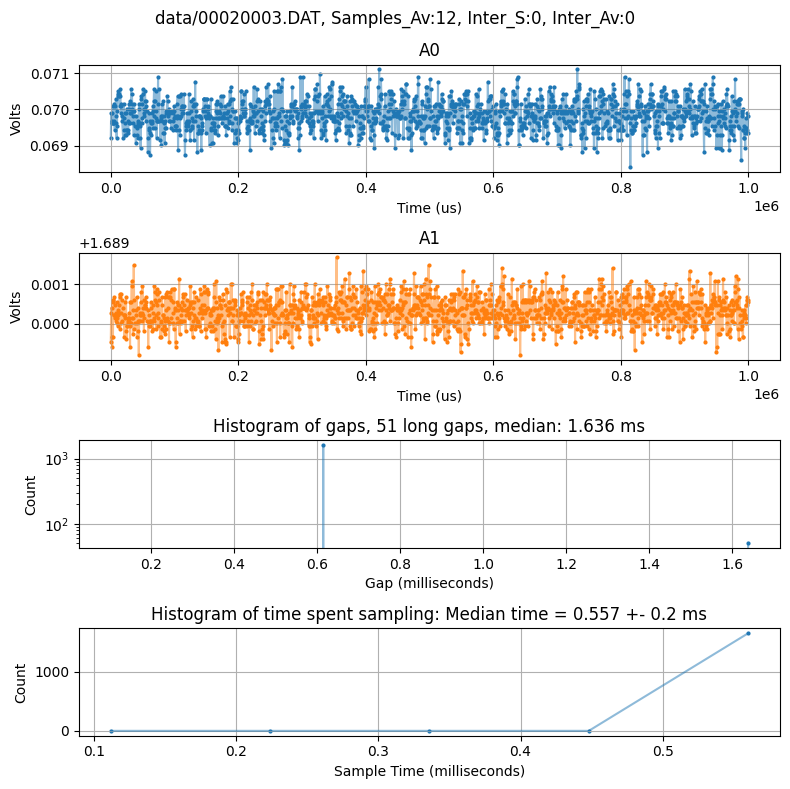

In [6]:
# histogram of all gaps 
h,tax = np.histogram(dt,range=[0,max(dt)],bins=int(max(dt)/100.))
# histogram of time spent sampling 
dt2 = t2-t1
h2,tax2 = np.histogram(dt2,range=[0, max(dt2)], bins=int(max(dt2)/100.))

fig, axs = plt.subplots(4)
fig.set_size_inches(8,8)

axs[0].scatter(t_mid,v0,s=4)
axs[0].plot(t_mid,v0,alpha=0.5, label ='A0')
axs[0].set_xlabel('Time (us)')
axs[0].set_ylabel('Volts')
axs[0].set_title('A0')
# axs[0].legend()
axs[0].grid()

axs[1].scatter(t_mid,v1,s=4, color ='C1')
axs[1].plot(t_mid,v1,alpha=0.5, color ='C1', label= 'A1')
axs[1].set_xlabel('Time (us)')
axs[1].set_ylabel('Volts')
axs[1].set_title('A1')
# axs[1].legend()
axs[1].grid()

#plot histogram of gaps in milliseconds:
axs[2].plot(tax[1:]/1e3,h,alpha=0.5)
axs[2].scatter(tax[1:]/1e3,h,s=4)
axs[2].set_yscale('log')
axs[2].set_xlabel('Gap (milliseconds)')
axs[2].set_ylabel('Count')
axs[2].set_title(f'Histogram of gaps, {len(long_gap)} long gaps, median: {round(np.median(dt[long_gap])/1e3,3)} ms')
axs[2].grid()

#plot histogram of gaps in milliseconds:
axs[3].plot(tax2[1:]/1e3,h2,alpha=0.5)
axs[3].scatter(tax2[1:]/1e3,h2,s=4)
axs[3].set_xlabel('Sample Time (milliseconds)')
axs[3].set_ylabel('Count')
axs[3].set_title(f'Histogram of time spent sampling: Median time = {round(t_s_med/1e3,3)} +- 0.2 ms')
axs[3].grid()

fig.suptitle(f'{path}, Samples_Av:{samples_averaged}, Inter_S:{inter_sample}, Inter_Av:{inter_average}')
fig.subplots_adjust(top=.93)
fig.tight_layout()

plt.savefig('plot2.png')


In [7]:
import numpy as np
data = [4,
        76,
        180,
        283,
        397,
        481,
        581,
        686,
        784,
        881,
        1031,
        1141,
        1244,
        1332,
        1435,
        1538,
        1628,
        1749,
        1835,
        2001,]

dtt = data - np.roll(data,1)
dtt = dtt[1:]
print(dtt)
print(np.median(dtt))


[ 72 104 103 114  84 100 105  98  97 150 110 103  88 103 103  90 121  86
 166]
103.0


In [8]:
data = [ 75934370,
        75934482,
        75934594,
        75934688,
        75934792,
        75934889,
        75935040,
        75935138,
        75935243,
        75935346,
        75935456,
        75935567,
        75935668,
    ]
dtt = data - np.roll(data,1)
dtt = dtt[1:]
print(dtt)
print(np.median(dtt))

[112 112  94 104  97 151  98 105 103 110 111 101]
104.5


In [9]:
52393674-52335995

57679